# 20210502 기준 Public Score 9등 코드

# 동서발전 태양광 발전량 예측 AI 경진대회

In [380]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 30)
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from fbprophet import Prophet
import lightgbm as lgb
from lightgbm import LGBMClassifier, plot_importance, plot_metric, plot_tree
from sklearn.metrics import mean_squared_error, roc_auc_score, precision_score, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. 문제 정의 (Problem identification)

나중에 정의할게요

# 2. 데이터수집 (Collecting data sets)

## (1) 데이콘 기본 데이터

- site_info.csv
- energy.csv
- dangjin_fcst_data.csv
- ulsan_fcst_data.csv
- dangjin_obs_data.csv
- ulsan_obs_data.csv
- sample_submission.csv

In [ ]:
site_info = pd.read_csv('data/base/site_info.csv')
energy = pd.read_csv('data/base/energy.csv')
dangjin_fcst = pd.read_csv('data/base/dangjin_fcst_data.csv')
ulsan_fcst = pd.read_csv('data/base/ulsan_fcst_data.csv')
dangjin_obs = pd.read_csv('data/base/dangjin_obs_data.csv')
ulsan_obs = pd.read_csv('data/base/ulsan_obs_data.csv')
sample_submission = pd.read_csv('data/base/sample_submission.csv')

## (2) 공공데이터포털

**한국동서발전(주)_태양광 발전량 현황**<br>
https://www.data.go.kr/data/15003553/fileData.do<br>
한국동서발전의 태양광 발전량 현황(용량, 발전량 등)을 제공(단위: kWh)

In [ ]:
new_energy = pd.read_csv('data/energy/new_energy.csv', index_col=0)
new_energy

## (3) 기상청 자료개방포털

**단기예보**<br>https://data.kma.go.kr/data/rmt/rmtList.do?code=420&pgmNo=572<br>
단기예보는 예보시점부터 3일 이내 기간에 대하여 행하는 예보로, 전국의 읍,면,동 단위로 상세한 날씨를 예보하기 위하여 2시부터 3시간 간격으로 일 8회 발표하며, 예보시간은 +4시간부터 +58~67시간까지 생산

7년치 데이터 1년씩 7개당 각 변수 7개, 총 49개의 csv를 모두 전처리한 후 임포트

In [ ]:
new_dangjin_fcst = pd.read_csv('data/dangjin_fcst/new_dangjin_fcst.csv', index_col=0)
new_ulsan_fcst = pd.read_csv('data/ulsan_fcst/new_ulsan_fcst.csv', index_col=0)
new_ulsan_fcst

**종관기상관측(ASOS)자료**<br>https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36<br>
종관기상관측이란 종관규모의 날씨를 파악하기 위하여 정해진 시각에 모든 관측소에서 같은 시각에 실시하는 지상관측
종관규모는 일기도에 표현되어 있는 보통의 고기압이나 저기압의 공간적 크기 및 수명을 말하며, 주로 매일의 날씨 현상을 뜻함

In [ ]:
dangjin_solar = pd.read_csv('data/dangjin_obs/OBS_ASOS_TIM.csv', names=['time', '일조량', '일사량'], header=0)
dangjin_solar.dropna()

## (4) Solcast

**Solar Radiation Data**<br>https://toolkit.solcast.com.au/live-forecast<br>
Zenith Angle 관측 데이터를 가져오기 위하여 Solcast 데이터 활용

In [ ]:
dangjin_zenith = pd.read_csv('./data/dangjin_obs/dangjin_zenith.csv')
ulsan_zenith = pd.read_csv('./data/ulsan_obs/ulsan_zenith.csv')
ulsan_zenith

## (5)  Stellarium

**Solar Data**<br>http://stellarium.org/<br>
태양거리 관측 데이터를 가져오기 위하여 Stellarium 데이터 활용

In [2]:
dangjin_distance = pd.read_csv('data/dangjin_obs/dangjin_stellarium.csv')
ulsan_distance = pd.read_csv('data/ulsan_obs/ulsan_stellarium.csv')
ulsan_distance

,이름,날짜 및 시간,방위각,고도,등급,위상,"거리, AU",이각
0,태양,2015.1.1 0:00,"+335°41'31.0""","-76°13'19.0""",-26.63,—,0.983361,—
1,태양,2015.1.1 1:00,"+33°35'52.8""","-75°07'57.2""",-26.63,—,0.983360,—
2,태양,2015.1.1 2:00,"+64°55'44.3""","-65°43'38.8""",-26.62,—,0.983357,—
3,태양,2015.1.1 3:00,"+80°03'45.1""","-54°06'54.2""",-26.60,—,0.983351,—
4,태양,2015.1.1 4:00,"+90°01'54.6""","-42°00'21.9""",-26.56,—,0.983344,—
...,...,...,...,...,...,...,...,...
54067,태양,2021.3.2 19:00,"+268°06'09.4""","-9°28'00.9""",-25.54,—,0.991109,—
54068,태양,2021.3.2 20:00,"+277°04'29.9""","-21°36'11.6""",-26.33,—,0.991128,—
54069,태양,2021.3.2 21:00,"+287°14'05.8""","-33°28'53.7""",-26.49,—,0.991146,—
54070,태양,2021.3.2 22:00,"+300°01'30.0""","-44°37'21.4""",-26.56,—,0.991163,—


# 3. 데이터 전처리 (Preprocessing)

## (1) 발전량 데이터 전처리

In [3]:
new_energy = pd.read_csv('data/energy/new_energy.csv', index_col=0)
new_energy

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2015-01-01 01:00:00,NaN,0.0,0.0,0.0
1,2015-01-01 02:00:00,NaN,0.0,0.0,0.0
2,2015-01-01 03:00:00,NaN,0.0,0.0,0.0
3,2015-01-01 04:00:00,NaN,0.0,0.0,0.0
4,2015-01-01 05:00:00,NaN,0.0,0.0,0.0
...,...,...,...,...,...
25627,2021-01-31 20:00:00,0.0,0.0,0.0,0.0
25628,2021-01-31 21:00:00,0.0,0.0,0.0,0.0
25629,2021-01-31 22:00:00,0.0,0.0,0.0,0.0
25630,2021-01-31 23:00:00,0.0,0.0,0.0,0.0


### 날짜 형식으로 변환 후 결측치 확인 

In [4]:
new_energy['time'] = pd.to_datetime(new_energy['time'])
new_energy.isna().sum()

time                     0
dangjin_floating     26328
dangjin_warehouse      120
dangjin                 72
ulsan                 1488
dtype: int64

## (2) 예보 데이터 전처리

In [5]:
new_dangjin_fcst = pd.read_csv('data/dangjin_fcst/new_dangjin_fcst.csv', index_col=0)
new_ulsan_fcst = pd.read_csv('data/ulsan_fcst/new_ulsan_fcst.csv', index_col=0)
new_ulsan_fcst

,Forecast time,forecast,Temperature,Precipitation,PrecRate,Humidity,WindSpeed,WindDirection,Cloud
0,2014-12-01 11:00:00,4.0,8.5,0.0,10.0,29.0,10.4,286.0,2.0
1,2014-12-01 11:00:00,7.0,4.5,0.0,10.0,24.0,12.5,295.0,2.0
2,2014-12-01 11:00:00,10.0,1.9,0.0,0.0,28.0,10.9,288.0,1.0
3,2014-12-01 11:00:00,13.0,0.4,0.0,0.0,36.0,7.7,287.0,1.0
4,2014-12-01 11:00:00,16.0,-0.7,0.0,0.0,38.0,6.0,292.0,1.0
...,...,...,...,...,...,...,...,...,...
17903,2021-04-01 08:00:00,52.0,20.0,0.0,30.0,65.0,4.8,174.0,4.0
17904,2021-04-01 08:00:00,55.0,20.0,0.0,30.0,65.0,4.8,193.0,4.0
17905,2021-04-01 08:00:00,58.0,18.0,1.0,60.0,75.0,2.3,200.0,4.0
17906,2021-04-01 08:00:00,61.0,17.0,1.0,60.0,80.0,1.6,184.0,4.0


### 결측치 확인

In [6]:
new_dangjin_fcst.isna().sum()

Forecast time       0
forecast            0
Temperature         0
Precipitation    4736
PrecRate         1500
Humidity         1832
WindSpeed        1500
WindDirection    1500
Cloud            6088
dtype: int64

In [7]:
new_ulsan_fcst.isna().sum()

Forecast time       0
forecast            0
Temperature         0
Precipitation    4736
PrecRate         1500
Humidity         1832
WindSpeed        1500
WindDirection    1500
Cloud            6088
dtype: int64

### 특정 시간 기준 예보 데이터로 변환 후 결측치 제거

In [400]:
def fcst_split(fcst_df, hour):
    
    # 14시 예보 기준 다음 날 예보 데이터 생성
    fcst_df['Forecast time'] = pd.to_datetime(fcst_df['Forecast time']) # 타입 변환
    fcst_df = fcst_df.rename({'Forecast time':'time'}, axis='columns') # 다루기 쉽게 컬럼명 변경
    
    if hour!=23: # 다음 날 24시간 예측치만 남기고 제외
        fcst_df = fcst_df[fcst_df['time'].dt.hour==hour] # 특정 시간 기준 예보 데이터 저장
        fcst_df = fcst_df[(fcst_df['forecast']>=(24-hour)&(fcst_df['forecast']<=(47-hour)))] 
    else:
        fcst_df_20 = fcst_df[fcst_df['time'].dt.hour==(hour-3)]
        fcst_df_20 = fcst_df_20[fcst_df_20['forecast']==4]
        fcst_df_23 = fcst_df[fcst_df['time'].dt.hour==(hour)]
        fcst_df_23 = fcst_df_23[(fcst_df_23['forecast']>=(24-hour)&(fcst_df_23['forecast']<=(47-hour)))] 
        fcst_df = pd.concat([fcst_df_20,fcst_df_23])
        
    fcst_df['time'] = fcst_df['time'] + fcst_df['forecast'].map(lambda x: pd.DateOffset(hours=x)) # 실측값
    fcst_df.drop(['forecast'], axis=1, inplace=True) # forecast 컬럼 제거
    fcst_df = fcst_df.sort_values(by=['time'], axis=0)
    fcst_df_all = pd.DataFrame() # 3시간 단위를 1시간 단위로 직선보간 (14년 12월 ~ 21년 4월)
    fcst_df_all['time'] = pd.date_range(start='2014-12-02 00:00:00', end='2021-04-01 21:00:00', freq='H')
    fcst_df_all = pd.merge(fcst_df_all, fcst_df, on='time', how='outer')
    fcst_df_all = fcst_df_all.interpolate()
    
    idx1 = list(fcst_df_all[(fcst_df_all['time']>'2015-05-22 21:00:00')&( # 2015년 결측치 제거
        fcst_df_all['time']<'2015-06-02 00:00:00')].index)
    idx2 = list(fcst_df_all[(fcst_df_all['time']>'2016-01-01 21:00:00')&( # 2016년 결측치 제거
        fcst_df_all['time']<'2016-02-02 00:00:00')].index)
    idx3 = list(fcst_df_all[(fcst_df_all['time']>'2017-06-09 21:00:00')&( # 2017년 결측치 제거
        fcst_df_all['time']<'2017-07-02 00:00:00')].index)
    
    fcst_df_all = fcst_df_all.drop(fcst_df_all.index[idx1+idx2+idx3]).reset_index(drop=True)
    
    return fcst_df_all

In [402]:
dangjin_fcst_11h = fcst_split(new_dangjin_fcst, hour=11)
dangjin_fcst_14h = fcst_split(new_dangjin_fcst, hour=14)
dangjin_fcst_17h = fcst_split(new_dangjin_fcst, hour=17)
dangjin_fcst_20h = fcst_split(new_dangjin_fcst, hour=20)
dangjin_fcst_23h = fcst_split(new_dangjin_fcst, hour=23).dropna().reset_index(drop=True)

ulsan_fcst_11h = fcst_split(new_ulsan_fcst, hour=11)
ulsan_fcst_14h = fcst_split(new_ulsan_fcst, hour=14)
ulsan_fcst_17h = fcst_split(new_ulsan_fcst, hour=17)
ulsan_fcst_20h = fcst_split(new_ulsan_fcst, hour=20)
ulsan_fcst_23h = fcst_split(new_ulsan_fcst, hour=23).dropna().reset_index(drop=True)
ulsan_fcst_23h

,time,Temperature,Precipitation,PrecRate,Humidity,WindSpeed,WindDirection,Cloud
0,2014-12-02 00:00:00,-0.8,0.0,0.0,58.000000,7.500000,292.000000,1.0
1,2014-12-02 01:00:00,-0.8,0.0,0.0,59.000000,9.533333,291.666667,1.0
2,2014-12-02 02:00:00,-0.8,0.0,0.0,60.000000,11.566667,291.333333,1.0
3,2014-12-02 03:00:00,-0.8,0.0,0.0,61.000000,13.600000,291.000000,1.0
4,2014-12-02 04:00:00,-0.9,0.0,0.0,61.333333,12.700000,292.000000,1.0
...,...,...,...,...,...,...,...,...
74237,2021-04-02 12:00:00,18.0,0.0,30.0,60.000000,4.300000,69.000000,4.0
74238,2021-04-02 15:00:00,18.0,0.0,30.0,60.000000,4.600000,60.000000,4.0
74239,2021-04-02 18:00:00,16.0,0.0,30.0,70.000000,3.600000,37.000000,4.0
74240,2021-04-02 21:00:00,14.0,0.0,20.0,80.000000,3.100000,37.000000,3.0


## (3) 관측 데이터 전처리

In [305]:
dangjin_obs = pd.read_csv('data/base/dangjin_obs_data.csv')
ulsan_obs = pd.read_csv('data/base/ulsan_obs_data.csv')
ulsan_obs

,지점,지점명,일시,기온(°C),풍속(m/s),풍향(16방위),습도(%),전운량(10분위)
0,152,울산,2018-03-01 00:00,8.2,3.9,340.0,98.0,10.0
1,152,울산,2018-03-01 01:00,7.0,4.1,320.0,97.0,10.0
2,152,울산,2018-03-01 02:00,6.5,5.9,290.0,80.0,NaN
3,152,울산,2018-03-01 03:00,6.2,4.6,320.0,79.0,3.0
4,152,울산,2018-03-01 04:00,6.7,4.5,320.0,73.0,1.0
...,...,...,...,...,...,...,...,...
25627,152,울산,2021-01-31 19:00,8.8,2.5,200.0,50.0,5.0
25628,152,울산,2021-01-31 20:00,8.7,3.9,200.0,49.0,1.0
25629,152,울산,2021-01-31 21:00,8.4,2.4,230.0,51.0,7.0
25630,152,울산,2021-01-31 22:00,9.4,3.3,230.0,51.0,8.0


### 결측치 확인

In [49]:
dangjin_obs.isna().sum()

지점              0
지점명             0
일시              0
기온(°C)         37
풍속(m/s)        36
풍향(16방위)       36
습도(%)          35
전운량(10분위)    3970
dtype: int64

In [50]:
ulsan_obs.isna().sum()

지점             0
지점명            0
일시             0
기온(°C)         4
풍속(m/s)        1
풍향(16방위)       1
습도(%)          1
전운량(10분위)    825
dtype: int64

### 결측치 제거 후 컬럼 이름 수정

In [310]:
def obs_processing(obs_df):
    obs_df = obs_df.dropna().reset_index(drop=True) # 결측치가 들어간 행 모두 제거
    obs_df = obs_df.rename({'일시':'time', '기온(°C)':'Temperature', '풍속(m/s)':'WindSpeed', 
                            '풍향(16방위)':'WindDirection', '습도(%)':'Humidity', 
                            '전운량(10분위)':'Cloud'}, axis='columns') # 예보 데이터와 컬럼 이름 매핑
    obs_df = obs_df[['time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
    obs_df['time'] = pd.to_datetime(obs_df['time']) # 타입 변환
    return obs_df

In [311]:
dangjin_obs = obs_processing(dangjin_obs)
ulsan_obs = obs_processing(ulsan_obs)
ulsan_obs

,time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-01 00:00:00,8.2,98.0,3.9,340.0,10.0
1,2018-03-01 01:00:00,7.0,97.0,4.1,320.0,10.0
2,2018-03-01 03:00:00,6.2,79.0,4.6,320.0,3.0
3,2018-03-01 04:00:00,6.7,73.0,4.5,320.0,1.0
4,2018-03-01 05:00:00,7.5,69.0,6.0,290.0,1.0
...,...,...,...,...,...,...
24796,2021-01-31 19:00:00,8.8,50.0,2.5,200.0,5.0
24797,2021-01-31 20:00:00,8.7,49.0,3.9,200.0,1.0
24798,2021-01-31 21:00:00,8.4,51.0,2.4,230.0,7.0
24799,2021-01-31 22:00:00,9.4,51.0,3.3,230.0,8.0


## (4) 태양거리 데이터 전처리

In [54]:
dangjin_distance = pd.read_csv('data/dangjin_obs/dangjin_stellarium.csv')
ulsan_distance = pd.read_csv('data/ulsan_obs/ulsan_stellarium.csv')
ulsan_distance

,이름,날짜 및 시간,방위각,고도,등급,위상,"거리, AU",이각
0,태양,2015.1.1 0:00,"+335°41'31.0""","-76°13'19.0""",-26.63,—,0.983361,—
1,태양,2015.1.1 1:00,"+33°35'52.8""","-75°07'57.2""",-26.63,—,0.983360,—
2,태양,2015.1.1 2:00,"+64°55'44.3""","-65°43'38.8""",-26.62,—,0.983357,—
3,태양,2015.1.1 3:00,"+80°03'45.1""","-54°06'54.2""",-26.60,—,0.983351,—
4,태양,2015.1.1 4:00,"+90°01'54.6""","-42°00'21.9""",-26.56,—,0.983344,—
...,...,...,...,...,...,...,...,...
54067,태양,2021.3.2 19:00,"+268°06'09.4""","-9°28'00.9""",-25.54,—,0.991109,—
54068,태양,2021.3.2 20:00,"+277°04'29.9""","-21°36'11.6""",-26.33,—,0.991128,—
54069,태양,2021.3.2 21:00,"+287°14'05.8""","-33°28'53.7""",-26.49,—,0.991146,—
54070,태양,2021.3.2 22:00,"+300°01'30.0""","-44°37'21.4""",-26.56,—,0.991163,—


In [55]:
def distance_processing(solar_df):
    solar_df = solar_df.rename({'날짜 및 시간':'time', '고도':'Altitude', 
                                '등급':'Rate', '거리, AU':'Distance'}, axis='columns')
    solar_df['Altitude'] = solar_df['Altitude'].str.split('°').str[0].astype(int)
    solar_df['time'] = pd.to_datetime(solar_df['time'])
    solar_df = solar_df[['time', 'Rate', 'Distance']]
    return solar_df
dangjin_distance = distance_processing(dangjin_distance)
ulsan_distance = distance_processing(ulsan_distance)
ulsan_distance

,time,Rate,Distance
0,2015-01-01 00:00:00,-26.63,0.983361
1,2015-01-01 01:00:00,-26.63,0.983360
2,2015-01-01 02:00:00,-26.62,0.983357
3,2015-01-01 03:00:00,-26.60,0.983351
4,2015-01-01 04:00:00,-26.56,0.983344
...,...,...,...
54067,2021-03-02 19:00:00,-25.54,0.991109
54068,2021-03-02 20:00:00,-26.33,0.991128
54069,2021-03-02 21:00:00,-26.49,0.991146
54070,2021-03-02 22:00:00,-26.56,0.991163


In [56]:
scaler1 = MinMaxScaler()
scaler2 = StandardScaler()

dangjin_distance['R_s1'] = scaler1.fit_transform(dangjin_distance['Distance'].values.reshape(-1, 1))
dangjin_distance['R_s2'] = scaler2.fit_transform(dangjin_distance['Distance'].values.reshape(-1, 1))
dangjin_distance['D_s1'] = scaler1.fit_transform(dangjin_distance['Distance'].values.reshape(-1, 1))
dangjin_distance['D_s2'] = scaler2.fit_transform(dangjin_distance['Distance'].values.reshape(-1, 1))
dangjin_distance['D_s3'] = np.log(dangjin_distance['Distance'])
dangjin_distance['D_s4'] = np.log2(dangjin_distance['Distance'])
dangjin_distance['D_s5'] = np.log10(dangjin_distance['Distance'])

ulsan_distance['R_s1'] = scaler1.fit_transform(ulsan_distance['Distance'].values.reshape(-1, 1))
ulsan_distance['R_s2'] = scaler2.fit_transform(ulsan_distance['Distance'].values.reshape(-1, 1))
ulsan_distance['D_s1'] = scaler1.fit_transform(ulsan_distance['Distance'].values.reshape(-1, 1))
ulsan_distance['D_s2'] = scaler2.fit_transform(ulsan_distance['Distance'].values.reshape(-1, 1))
ulsan_distance['D_s3'] = np.log(ulsan_distance['Distance'])
ulsan_distance['D_s4'] = np.log2(ulsan_distance['Distance'])
ulsan_distance['D_s5'] = np.log10(ulsan_distance['Distance'])
ulsan_distance

,time,Rate,Distance,R_s1,R_s2,D_s1,D_s2,D_s3,D_s4,D_s5
0,2015-01-01 00:00:00,-26.63,0.983361,0.004143,-1.379143,0.004143,-1.379143,-0.016779,-0.024207,-0.007287
1,2015-01-01 01:00:00,-26.63,0.983360,0.004113,-1.379227,0.004113,-1.379227,-0.016780,-0.024208,-0.007287
2,2015-01-01 02:00:00,-26.62,0.983357,0.004023,-1.379480,0.004023,-1.379480,-0.016783,-0.024213,-0.007289
3,2015-01-01 03:00:00,-26.60,0.983351,0.003845,-1.379985,0.003845,-1.379985,-0.016789,-0.024222,-0.007291
4,2015-01-01 04:00:00,-26.56,0.983344,0.003636,-1.380574,0.003636,-1.380574,-0.016796,-0.024232,-0.007295
...,...,...,...,...,...,...,...,...,...,...
54067,2021-03-02 19:00:00,-25.54,0.991109,0.235054,-0.727133,0.235054,-0.727133,-0.008931,-0.012884,-0.003879
54068,2021-03-02 20:00:00,-26.33,0.991128,0.235620,-0.725534,0.235620,-0.725534,-0.008912,-0.012857,-0.003870
54069,2021-03-02 21:00:00,-26.49,0.991146,0.236157,-0.724019,0.236157,-0.724019,-0.008893,-0.012831,-0.003862
54070,2021-03-02 22:00:00,-26.56,0.991163,0.236663,-0.722589,0.236663,-0.722589,-0.008876,-0.012806,-0.003855


## (5) Zenith 데이터 전처리

In [57]:
dangjin_zenith = pd.read_csv('./data/dangjin_obs/dangjin_zenith.csv')
ulsan_zenith = pd.read_csv('./data/ulsan_obs/ulsan_zenith.csv')
dangjin_zenith

,Year,Month,Day,Hour,Minute,Tamb,Albedo,Azimuth,Cloudopacity,DewPoint,DHI,DNI,EBH,GHI,GtiFixedTilt,GtiTracking,Pw,Pressure,SnowDepth,WindDir,WindVel,Zenith
0,Year,Month,Day,Hour,Minute,[deg.C],[(0 - 1)],[degree],[%],[deg.C],[W/m2],[W/m2],[W/m2],[W/m2],[W/m2],[W/m2],[cm],[mbar],[cm],[degree],[m/s],[degree]
1,2015,1,1,0,0,-5.2,0.12,-41,0,-14.8,0,0,0,0,0,0,0.24,1016.9,0,326,8.4,161
2,2015,1,1,1,0,-5.6,0.12,-67,0,-15.4,0,0,0,0,0,0,0.23,1017,0,327,8.2,152
3,2015,1,1,2,0,-6,0.12,-82,0,-15.7,0,0,0,0,0,0,0.23,1017,0,327,8,140
4,2015,1,1,3,0,-6.2,0.12,-92,0,-15.5,0,0,0,0,0,0,0.23,1017,0,327,7.9,128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55292,2021,4,22,19,0,12.7,0.09,62,48.8,7.6,0,0,0,0,0,0,2.25,1018.0,0.0,300,2.1,105
55293,2021,4,22,20,0,12.8,0.09,50,63.7,7.2,0,0,0,0,0,0,2.23,1017.9,0.0,17,2.7,115
55294,2021,4,22,21,0,13.2,0.09,36,48.8,6.7,0,0,0,0,0,0,2.14,1017.3,0.0,45,5.4,123
55295,2021,4,22,22,0,13.6,0.09,20,75.4,6.4,0,0,0,0,0,0,2.02,1016.9,0.0,62,5.8,129


In [58]:
dangjin_zenith = dangjin_zenith.drop(0).reset_index(drop=True)
dangjin_zenith = dangjin_zenith.astype('float64')
dangjin_zenith['time'] = pd.date_range(start='2015-01-01 00:00:00', end='2021-04-22 23:00:00', freq='H')
dangjin_zenith = dangjin_zenith[['time', 'Zenith']]

ulsan_zenith = ulsan_zenith.drop(0).reset_index(drop=True)
ulsan_zenith = ulsan_zenith.astype('float64')
ulsan_zenith['time'] = pd.date_range(start='2015-01-01 00:00:00', end='2021-04-25 23:00:00', freq='H')
ulsan_zenith = ulsan_zenith[['time', 'Zenith']]
ulsan_zenith

,time,Zenith
0,2015-01-01 00:00:00,161.0
1,2015-01-01 01:00:00,150.0
2,2015-01-01 02:00:00,138.0
3,2015-01-01 03:00:00,126.0
4,2015-01-01 04:00:00,114.0
...,...,...
55363,2021-04-25 19:00:00,107.0
55364,2021-04-25 20:00:00,117.0
55365,2021-04-25 21:00:00,125.0
55366,2021-04-25 22:00:00,130.0


## (6) 복사열 데이터 전처리

In [59]:
dangjin_solar = pd.read_csv('data/dangjin_obs/OBS_ASOS_TIM.csv', names=['time', 'Sunlight', 'Radiation']
                            , header=0).fillna(0)[:26239]
dangjin_solar['time'] = pd.to_datetime(dangjin_solar['time'])
dangjin_solar

,time,Sunlight,Radiation
0,2018-03-02 01:00:00,0.0,0.0
1,2018-03-02 02:00:00,0.0,0.0
2,2018-03-02 03:00:00,0.0,0.0
3,2018-03-02 04:00:00,0.0,0.0
4,2018-03-02 05:00:00,0.0,0.0
...,...,...,...
26234,2021-02-28 20:00:00,0.0,0.0
26235,2021-02-28 21:00:00,0.0,0.0
26236,2021-02-28 22:00:00,0.0,0.0
26237,2021-02-28 23:00:00,0.0,0.0


# 4. 탐색적 데이터 분석 (Exploratory Data Analysis)

### 예보시간 별 관측 데이터 비교 시각화

In [381]:
def compare_fcst_obs(fcst_df, obs_df):
    
    obs_df['time'] = pd.to_datetime(obs_df['time'])
    
    compare_df = pd.merge(obs_df, fcst_df, on='time', how='inner')
    
    error_temperature = mean_squared_error(compare_df['Temperature_x'], compare_df['Temperature_y'])
    error_humidity = mean_squared_error(compare_df['Humidity_x'], compare_df['Humidity_y'])
    error_windspeed = mean_squared_error(compare_df['WindSpeed_x'], compare_df['WindSpeed_y'])
    error_winddirection = mean_squared_error(compare_df['WindDirection_x'], compare_df['WindDirection_y'])
    error_cloud = mean_squared_error(compare_df['Cloud_x'], compare_df['Cloud_y'])
    
    return np.array([error_temperature, error_humidity, error_windspeed, error_winddirection, error_cloud])

In [456]:
compare_df = pd.DataFrame()
compare_df['11h'] = compare_fcst_obs(dangjin_fcst_11h, dangjin_obs)
compare_df['14h'] = compare_fcst_obs(dangjin_fcst_14h, dangjin_obs)
compare_df['17h'] = compare_fcst_obs(dangjin_fcst_17h, dangjin_obs)
compare_df['20h'] = compare_fcst_obs(dangjin_fcst_20h, dangjin_obs)
compare_df['23h'] = compare_fcst_obs(dangjin_fcst_23h, dangjin_obs)
compare_df

,11h,14h,17h,20h,23h
0,2.990017,2.987554,2.893376,2.924703,2.920766
1,166.003978,166.709114,159.314071,159.343523,159.244355
2,9.065349,9.191337,8.904729,8.987842,9.101408
3,24766.090802,25114.353762,24943.666405,24838.441922,24812.583772
4,18.706565,18.760627,18.584501,18.678048,18.637971


In [457]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
fig = make_subplots(rows=1, cols=5,
                    subplot_titles=tuple([str(i)+'\'s error' for i in list(dangjin_fcst_14h.columns[1:])]))

for i in range(5):
    fig.add_trace(go.Scatter(x=compare_df.iloc[i].index, y=compare_df.iloc[i],
                                 showlegend=False, mode = 'lines', name='{} Sample'.format(i)),
                     row=1, col=i+1)
        
fig.update_layout(height=400, width=1000, title='MSE Plot', 
                  title_font_size=20, title_font_family='Times New Roman')
fig.show()

### 예보 데이터와 관측 데이터 비교 시각화

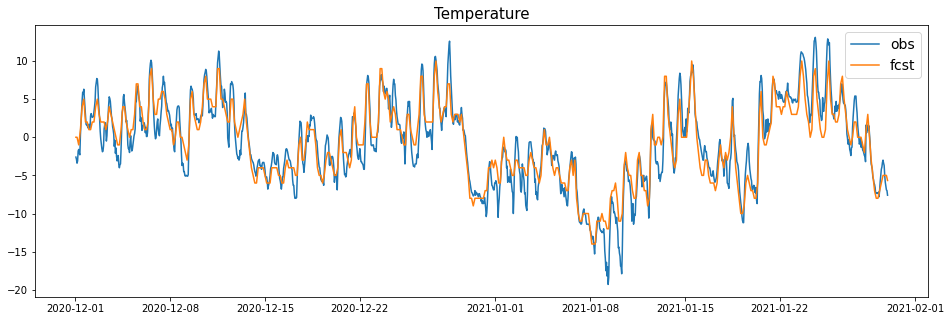

In [212]:
plt.figure(figsize=(16, 5))
obs_idx = dangjin_obs[(dangjin_obs['time']>'2020-12-01')&(dangjin_obs['time']<'2021-01-30')].index
fcst_idx = dangjin_fcst_2[(dangjin_fcst_11h['time']>'2020-12-01')&(dangjin_fcst_11h['time']<'2021-01-30')].index
plt.plot(dangjin_obs.loc[obs_idx, 'time'], dangjin_obs.loc[obs_idx, 'Temperature'], label='obs')
plt.plot(dangjin_fcst_11h.loc[fcst_idx, 'time'], dangjin_fcst_11h.loc[fcst_idx, 'Temperature'], label='fcst')
plt.title('Temperature', fontsize=15)
plt.legend(prop={'size':14}, loc='best')
plt.show()

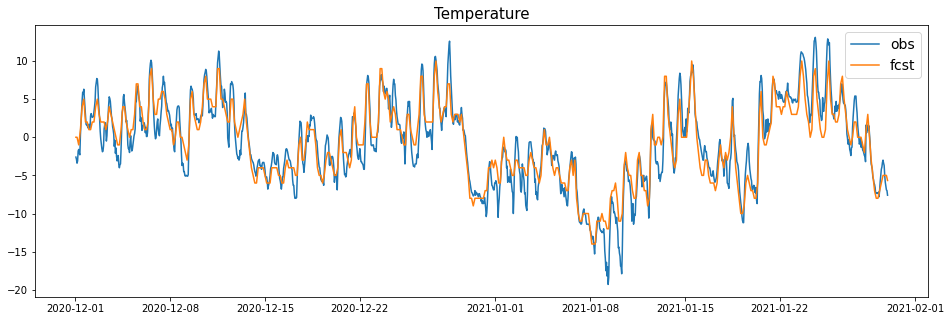

In [53]:
plt.figure(figsize=(16, 5))
obs_idx = dangjin_obs[(dangjin_obs['time']>'2020-12-01')&(dangjin_obs['time']<'2021-01-30')].index
fcst_idx = dangjin_fcst_2[(dangjin_fcst_2['time']>'2020-12-01')&(dangjin_fcst_2['time']<'2021-01-30')].index
plt.plot(dangjin_obs.loc[obs_idx, 'time'], dangjin_obs.loc[obs_idx, 'Temperature'], label='obs')
plt.plot(dangjin_fcst_2.loc[fcst_idx, 'time'], dangjin_fcst_2.loc[fcst_idx, 'Temperature'], label='fcst')
plt.title('Temperature', fontsize=15)
plt.legend(prop={'size':14}, loc='best')
plt.show()

# 5. 변수 조정 (Feature Engineering)

## (1) 날짜 변수 생성

In [458]:
def make_calendar_feature(fcst_df):
    
    # 예보 시간 및 날짜 정보 feature로 추가
    fcst_df['date'] = fcst_df['time'].astype(str).str.split(' ').str[0]
    fcst_df['hour'] = fcst_df['time'].astype(str).str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    fcst_df['year'] = fcst_df['date'].str.split('-').str[0].astype(int)
    fcst_df['month'] = fcst_df['date'].str.split('-').str[1].astype(int)
    fcst_df['day'] = fcst_df['date'].str.split('-').str[2].astype(int)
    fcst_df = fcst_df[['time', 'Temperature', 'Precipitation', 'PrecRate', 'Humidity', 'WindSpeed', 
                       'WindDirection', 'Cloud', 'hour', 'year', 'month', 'day']]
    return fcst_df

In [459]:
dangjin_fcst_3 = make_calendar_feature(dangjin_fcst_17h)
ulsan_fcst_3 = make_calendar_feature(ulsan_fcst_17h)
ulsan_fcst_3

,time,Temperature,Precipitation,PrecRate,Humidity,WindSpeed,WindDirection,Cloud,hour,year,month,day
0,2014-12-02 00:00:00,-0.400000,0.0,0.0,58.000000,7.500000,292.000000,1.0,0,2014,12,2
1,2014-12-02 01:00:00,-0.500000,0.0,0.0,59.000000,7.466667,291.666667,1.0,1,2014,12,2
2,2014-12-02 02:00:00,-0.600000,0.0,0.0,60.000000,7.433333,291.333333,1.0,2,2014,12,2
3,2014-12-02 03:00:00,-0.700000,0.0,0.0,61.000000,7.400000,291.000000,1.0,3,2014,12,2
4,2014-12-02 04:00:00,-0.733333,0.0,0.0,61.333333,7.233333,292.000000,1.0,4,2014,12,2
...,...,...,...,...,...,...,...,...,...,...,...,...
76487,2021-04-02 12:00:00,18.000000,0.0,30.0,60.000000,4.300000,69.000000,4.0,12,2021,4,2
76488,2021-04-02 15:00:00,18.000000,0.0,30.0,60.000000,4.600000,60.000000,4.0,15,2021,4,2
76489,2021-04-02 18:00:00,16.000000,0.0,30.0,70.000000,3.600000,37.000000,4.0,18,2021,4,2
76490,2021-04-02 21:00:00,14.000000,0.0,20.0,80.000000,3.100000,37.000000,3.0,21,2021,4,2


## (2) 태양거리 변수 생성

### 관측값을 이용하여 Prophet을 사용해 Val 태양거리 예측

In [100]:
# prophet_df = dangjin_distance.rename({'time':'ds', 'Distance':'y'}, axis='columns')
# dangjin_distance_val_true = prophet_df[(prophet_df['ds']>='2021-01-01 01:00:00')&(
#     prophet_df['ds']<='2021-02-01 00:00:00')]['y'].to_numpy()
# prophet_df = prophet_df[prophet_df['ds']<='2021-01-01 00:00:00']
# m = Prophet(seasonality_mode='additive', yearly_seasonality=20, weekly_seasonality=10, 
#             daily_seasonality=25, changepoint_prior_scale=0.04)
# m.fit(prophet_df)
# future = m.make_future_dataframe(periods=31*24, freq='H')
# forecast = m.predict(future)
# dangjin_distance_val_pred = forecast['yhat'][-31*24:].to_numpy()
# r2_score(dangjin_distance_val_true, dangjin_distance_val_pred) # 예측을 잘 했는지 확인하기 위해 r2_score 체크

In [101]:
# prophet_df = ulsan_distance.rename({'time':'ds', 'Distance':'y'}, axis='columns')
# ulsan_distance_val_true = prophet_df[(prophet_df['ds']>='2021-01-01 01:00:00')&(
#     prophet_df['ds']<='2021-02-01 00:00:00')]['y'].to_numpy()
# prophet_df = prophet_df[prophet_df['ds']<='2021-01-01 00:00:00']
# m = Prophet(seasonality_mode='additive', yearly_seasonality=20, weekly_seasonality=10, 
#             daily_seasonality=25, changepoint_prior_scale=0.04)
# m.fit(prophet_df)
# future = m.make_future_dataframe(periods=31*24, freq='H')
# forecast = m.predict(future)
# ulsan_distance_val_pred = forecast['yhat'][-31*24:].to_numpy()
# r2_score(ulsan_distance_val_true, ulsan_distance_val_pred) # 예측을 잘 했는지 확인하기 위해 r2_score 체크

### 관측값을 이용하여 Prophet을 사용해 Test 태양거리 예측

In [102]:
# prophet_df = dangjin_distance.rename({'time':'ds', 'Distance':'y'}, axis='columns')
# dangjin_distance_test_true = prophet_df[(prophet_df['ds']>='2021-02-01 01:00:00')&(
#     prophet_df['ds']<='2021-03-01 00:00:00')]['y'].to_numpy()
# prophet_df = prophet_df[prophet_df['ds']<='2021-02-01 00:00:00']
# m = Prophet(seasonality_mode='additive', yearly_seasonality=20, weekly_seasonality=10, 
#             daily_seasonality=25, changepoint_prior_scale=0.04)
# m.fit(prophet_df)
# future = m.make_future_dataframe(periods=28*24, freq='H')
# forecast = m.predict(future)
# dangjin_distance_test_pred = forecast['yhat'][-28*24:].to_numpy()
# r2_score(dangjin_distance_test_true, dangjin_distance_test_pred) # 예측을 잘 했는지 확인하기 위해 r2_score 체크

In [103]:
# prophet_df = ulsan_distance.rename({'time':'ds', 'Distance':'y'}, axis='columns')
# ulsan_distance_test_true = prophet_df[(prophet_df['ds']>='2021-02-01 01:00:00')&(
#     prophet_df['ds']<='2021-03-01 00:00:00')]['y'].to_numpy()
# prophet_df = prophet_df[prophet_df['ds']<='2021-02-01 00:00:00']
# m = Prophet(seasonality_mode='additive', yearly_seasonality=20, weekly_seasonality=10, 
#             daily_seasonality=25, changepoint_prior_scale=0.04)
# m.fit(prophet_df)
# future = m.make_future_dataframe(periods=28*24, freq='H')
# forecast = m.predict(future)
# ulsan_distance_test_pred = forecast['yhat'][-28*24:].to_numpy()
# r2_score(ulsan_distance_test_true, ulsan_distance_test_pred) # 예측을 잘 했는지 확인하기 위해 r2_score 체크

### 관측한 태양거리를 Train 데이터,  예측한 태양거리를 Val, Test 데이터에 삽입

In [460]:
dangjin_fcst_4 = pd.merge(dangjin_fcst_3, dangjin_distance[['time', 'Distance']], on='time', how='inner')
ulsan_fcst_4 = pd.merge(ulsan_fcst_3, dangjin_distance[['time', 'Distance']], on='time', how='inner')
ulsan_fcst_4

,time,Temperature,Precipitation,PrecRate,Humidity,WindSpeed,WindDirection,Cloud,hour,year,month,day,Distance
0,2015-01-01 00:00:00,-0.800000,0.0,0.000000,45.000000,8.700000,294.000000,1.000000,0,2015,1,1,0.983361
1,2015-01-01 00:00:00,-1.400000,0.0,0.000000,45.000000,8.500000,294.000000,1.000000,0,2015,1,1,0.983361
2,2015-01-01 00:00:00,-1.000000,0.0,0.000000,45.000000,3.800000,297.000000,1.000000,0,2015,1,1,0.983361
3,2015-01-01 01:00:00,-1.600000,0.0,3.333333,45.000000,5.433333,293.666667,1.333333,1,2015,1,1,0.983360
4,2015-01-01 02:00:00,-2.200000,0.0,6.666667,45.000000,7.066667,290.333333,1.666667,2,2015,1,1,0.983357
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74449,2021-03-02 21:00:00,4.000000,0.0,10.000000,60.000000,3.700000,20.000000,3.000000,21,2021,3,2,0.991145
74450,2021-03-02 21:00:00,4.000000,0.0,10.000000,55.000000,4.500000,17.000000,3.000000,21,2021,3,2,0.991145
74451,2021-03-02 21:00:00,4.000000,0.0,10.000000,55.000000,4.800000,18.000000,3.000000,21,2021,3,2,0.991145
74452,2021-03-02 22:00:00,3.666667,0.0,10.000000,56.666667,4.500000,17.000000,3.000000,22,2021,3,2,0.991162


In [127]:
# val_idx = dangjin_fcst_4[(dangjin_fcst_4['time']>='2021-01-01 01:00:00')&(
#     dangjin_fcst_4['time']<='2021-02-01 00:00:00')].index

# test_idx = dangjin_fcst_4[(dangjin_fcst_4['time']>='2021-02-01 01:00:00')&(
#     dangjin_fcst_4['time']<='2021-03-01 00:00:00')].index

# dangjin_fcst_4['Distance'][val_idx] = dangjin_distance_val_pred
# dangjin_fcst_4['Distance'][test_idx] = dangjin_distance_test_pred
# ulsan_fcst_4['Distance'][val_idx] = ulsan_distance_val_pred
# ulsan_fcst_4['Distance'][test_idx] = ulsan_distance_test_pred

# dangjin_fcst_4

## (3) 제니스각 변수 생성

In [461]:
dangjin_fcst_5 = pd.merge(dangjin_fcst_4, dangjin_zenith[['time', 'Zenith']], on='time', how='inner')
ulsan_fcst_5 = pd.merge(ulsan_fcst_4, ulsan_zenith[['time', 'Zenith']], on='time', how='inner')
ulsan_fcst_5

,time,Temperature,Precipitation,PrecRate,Humidity,WindSpeed,WindDirection,Cloud,hour,year,month,day,Distance,Zenith
0,2015-01-01 00:00:00,-0.800000,0.0,0.000000,45.000000,8.700000,294.000000,1.000000,0,2015,1,1,0.983361,161.0
1,2015-01-01 00:00:00,-1.400000,0.0,0.000000,45.000000,8.500000,294.000000,1.000000,0,2015,1,1,0.983361,161.0
2,2015-01-01 00:00:00,-1.000000,0.0,0.000000,45.000000,3.800000,297.000000,1.000000,0,2015,1,1,0.983361,161.0
3,2015-01-01 01:00:00,-1.600000,0.0,3.333333,45.000000,5.433333,293.666667,1.333333,1,2015,1,1,0.983360,150.0
4,2015-01-01 02:00:00,-2.200000,0.0,6.666667,45.000000,7.066667,290.333333,1.666667,2,2015,1,1,0.983357,138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74449,2021-03-02 21:00:00,4.000000,0.0,10.000000,60.000000,3.700000,20.000000,3.000000,21,2021,3,2,0.991145,140.0
74450,2021-03-02 21:00:00,4.000000,0.0,10.000000,55.000000,4.500000,17.000000,3.000000,21,2021,3,2,0.991145,140.0
74451,2021-03-02 21:00:00,4.000000,0.0,10.000000,55.000000,4.800000,18.000000,3.000000,21,2021,3,2,0.991145,140.0
74452,2021-03-02 22:00:00,3.666667,0.0,10.000000,56.666667,4.500000,17.000000,3.000000,22,2021,3,2,0.991162,148.0


### 제니스 각도는 월마다 비슷한 양상을 보이는 것을 확인

In [281]:
zenith_201901 = dangjin_fcst_5[(dangjin_fcst_5['time']>='2019-01-01 01:00:00')&(
    dangjin_fcst_5['time']<='2019-02-01 00:00:00')]['Zenith'].values
zenith_202001 = dangjin_fcst_5[(dangjin_fcst_5['time']>='2020-01-01 01:00:00')&(
    dangjin_fcst_5['time']<='2020-02-01 00:00:00')]['Zenith'].values
(zenith_202001-zenith_201901).sum() # 2019년 1월과 2020년 1월의 제니스 각도가 동일

0.0

In [282]:
zenith_201810 = dangjin_fcst_5[(dangjin_fcst_5['time']>='2018-10-01 01:00:00')&(
    dangjin_fcst_5['time']<='2018-11-01 00:00:00')]['Zenith'].values
zenith_201910 = dangjin_fcst_5[(dangjin_fcst_5['time']>='2019-10-01 01:00:00')&(
    dangjin_fcst_5['time']<='2019-11-01 00:00:00')]['Zenith'].values
(zenith_201910-zenith_201810).sum() # 2018년 10월과 2019년 10월의 제니스 각도가 동일

0.0

In [283]:
zenith_201907 = dangjin_fcst_5[(dangjin_fcst_5['time']>='2019-07-01 01:00:00')&(
    dangjin_fcst_5['time']<='2019-08-01 00:00:00')]['Zenith'].values
zenith_201912 = dangjin_fcst_5[(dangjin_fcst_5['time']>='2020-12-01 01:00:00')&(
    dangjin_fcst_5['time']<='2021-01-01 00:00:00')]['Zenith'].values
(zenith_201912-zenith_201907).sum() # 2019년 7월과 2019년 12월의 Zenith각도는 상이

24667.0

### Val, Test 제니스 각도에 전년도 제니스 각도 관측값 사용

In [284]:
val_idx = dangjin_fcst_5[(dangjin_fcst_5['time']>='2021-01-01 01:00:00')&(
    dangjin_fcst_5['time']<='2021-02-01 00:00:00')].index
test_idx = dangjin_fcst_5[(dangjin_fcst_5['time']>='2021-02-01 01:00:00')&(
    dangjin_fcst_5['time']<='2021-02-28 23:00:00')].index # 2020년은 2월 29일까지 있으므로 28일 23시까지만 인덱스 추출

dangjin_fcst_5['Zenith'][val_idx] = dangjin_fcst_5[(dangjin_fcst_5['time']>='2020-01-01 01:00:00')&(
    dangjin_fcst_5['time']<='2020-02-01 00:00:00')]['Zenith'].values
dangjin_fcst_5['Zenith'][test_idx] = dangjin_fcst_5[(dangjin_fcst_5['time']>='2020-02-01 01:00:00')&(
    dangjin_fcst_5['time']<='2020-02-28 23:00:00')]['Zenith'].values
ulsan_fcst_5['Zenith'][val_idx] = ulsan_fcst_5[(ulsan_fcst_5['time']>='2020-01-01 01:00:00')&(
    ulsan_fcst_5['time']<='2020-02-01 00:00:00')]['Zenith'].values
ulsan_fcst_5['Zenith'][test_idx] = ulsan_fcst_5[(ulsan_fcst_5['time']>='2020-02-01 01:00:00')&(
    ulsan_fcst_5['time']<='2020-02-28 23:00:00')]['Zenith'].values

## (X) 일사량 변수 생성

In [133]:
# prophet_df = dangjin_solar.rename({'time':'ds', 'Radiation':'y'}, axis='columns')
# dangjin_radiation_val_true = prophet_df[(prophet_df['ds']>='2021-01-01 01:00:00')&(
#     prophet_df['ds']<='2021-02-01 00:00:00')]['y'].to_numpy()
# prophet_df = prophet_df[prophet_df['ds']<='2021-01-01 00:00:00']
# m = Prophet(seasonality_mode='additive', yearly_seasonality=20, weekly_seasonality=10, 
#             daily_seasonality=25, changepoint_prior_scale=0.04)
# m.fit(prophet_df)
# future = m.make_future_dataframe(periods=31*24, freq='H')
# forecast = m.predict(future)
# dangjin_radiation_val_pred = forecast['yhat'][-31*24:].to_numpy()
# r2_score(dangjin_radiation_val_true, dangjin_radiation_val_pred) # 예측을 잘 했는지 확인하기 위해 r2_score 체크

In [134]:
# prophet_df = dangjin_solar[['time', 'Sunlight']].rename({'time':'ds', 'Sunlight':'y'}, axis='columns')
# dangjin_sunlight_val_true = prophet_df[(prophet_df['ds']>='2021-01-01 01:00:00')&(
#     prophet_df['ds']<='2021-02-01 00:00:00')]['y'].to_numpy()
# prophet_df = prophet_df[prophet_df['ds']<='2021-01-01 00:00:00']
# m = Prophet(seasonality_mode='additive', yearly_seasonality=20, weekly_seasonality=10, 
#             daily_seasonality=20, changepoint_prior_scale=0.03)
# m.fit(prophet_df)
# future = m.make_future_dataframe(periods=31*24, freq='H')
# forecast = m.predict(future)
# dangjin_sunlight_val_pred = forecast['yhat'][-31*24:].to_numpy()
# r2_score(dangjin_sunlight_val_true, dangjin_sunlight_val_pred) # 예측을 잘 했는지 확인하기 위해 r2_score 체크

In [135]:
# prophet_df = dangjin_solar[['time', 'Sunlight']].rename({'time':'ds', 'Sunlight':'y'}, axis='columns')
# dangjin_sunlight_val_true = prophet_df[(prophet_df['ds']>='2021-01-01 01:00:00')&(
#     prophet_df['ds']<='2021-02-01 00:00:00')]['y'].to_numpy()
# prophet_df = prophet_df[prophet_df['ds']<='2021-01-01 00:00:00']
# m = Prophet(seasonality_mode='additive', yearly_seasonality=20, weekly_seasonality=10, 
#             daily_seasonality=25, changepoint_prior_scale=0.03)
# m.fit(prophet_df)
# future = m.make_future_dataframe(periods=31*24, freq='H')
# forecast = m.predict(future)
# dangjin_sunlight_val_pred = forecast['yhat'][-31*24:].to_numpy()
# r2_score(dangjin_sunlight_val_true, dangjin_sunlight_val_pred) # 예측을 잘 했는지 확인하기 위해 r2_score 체크

In [136]:
# prophet_df = dangjin_solar[['time', 'Sunlight']].rename({'time':'ds', 'Sunlight':'y'}, axis='columns')
# dangjin_sunlight_val_true = prophet_df[(prophet_df['ds']>='2021-01-01 01:00:00')&(
#     prophet_df['ds']<='2021-02-01 00:00:00')]['y'].to_numpy()
# prophet_df = prophet_df[prophet_df['ds']<='2021-01-01 00:00:00']
# m = Prophet(seasonality_mode='additive', yearly_seasonality=20, weekly_seasonality=10, 
#             daily_seasonality=25, changepoint_prior_scale=0.04)
# m.fit(prophet_df)
# future = m.make_future_dataframe(periods=31*24, freq='H')
# forecast = m.predict(future)
# dangjin_sunlight_val_pred = forecast['yhat'][-31*24:].to_numpy()
# r2_score(dangjin_sunlight_val_true, dangjin_sunlight_val_pred) # 예측을 잘 했는지 확인하기 위해 r2_score 체크

In [137]:
# b = dangjin_solar.set_index('time').Radiation.resample('1D').mean().reset_index().rename(
#     {'Radiation':'Rad_mean'}, axis='columns')
# c = dangjin_solar.set_index('time').Radiation.resample('1D').sum().reset_index().rename(
#     {'Radiation':'Rad_sum'}, axis='columns')[['Rad_sum']]
# d = dangjin_solar.set_index('time').Radiation.resample('1D').max().reset_index().rename(
#     {'Radiation':'Rad_max'}, axis='columns')[['Rad_max']]

# b = pd.concat([b, c, d], axis=1)
# b

In [138]:
# prophet_df = b.rename({'time':'ds', 'Rad_sum':'y'}, axis='columns')
# dangjin_distance_val_true = prophet_df[(prophet_df['ds']>='2021-01-01')&(
#     prophet_df['ds']<='2021-01-31')]['y'].to_numpy()
# prophet_df = prophet_df[prophet_df['ds']<='2020-12-31 00:00:00']
# m = Prophet(seasonality_mode='additive', yearly_seasonality=8, weekly_seasonality=10, 
#             daily_seasonality=10, changepoint_prior_scale=0.03)
# m.fit(prophet_df)
# future = m.make_future_dataframe(periods=31, freq='D')
# forecast = m.predict(future)
# dangjin_distance_val_pred = forecast['yhat'][-31:].to_numpy()
# r2_score(dangjin_distance_val_true, dangjin_distance_val_pred) # 예측을 잘 했는지 확인하기 위해 r2_score 체크

## (4) 최종 변수

In [528]:
dangjin_floating_df = dangjin_fcst_5.drop(['Precipitation'], axis=1)
dangjin_warehouse_df = dangjin_fcst_5.drop(['Precipitation'], axis=1)
dangjin_df = dangjin_fcst_5.drop(['Precipitation'], axis=1)
ulsan_df =ulsan_fcst_5.drop(['Precipitation'], axis=1)

# 6. Model training

## (1) Train, Validation, Test Set

In [463]:
def make_train_val_dropzero(feature_df, target_df, location):
    
    target_df = target_df[['time', location]].dropna()
    target_df['time'] = pd.to_datetime(target_df['time'])
    
    train_idx = feature_df[feature_df['time']<='2021-01-02 00:00:00'].index
    val_idx = feature_df[(feature_df['time']>='2021-01-02 01:00:00')&(
        feature_df['time']<='2021-02-01 00:00:00')].index
    
    test_idx = feature_df[(feature_df['time']>='2021-02-01 01:00:00')&(
        feature_df['time']<='2021-03-01 00:00:00')].index
    
    train_df = pd.merge(feature_df.iloc[train_idx], target_df, on='time', how='inner')
    val_df = pd.merge(feature_df.iloc[val_idx], target_df, on='time', how='inner')
    test_x = feature_df.iloc[test_idx].drop(['time'], axis=1)
    
    train_x = train_df.iloc[:, :-1].drop(['time'], axis=1)
    train_y = train_df.iloc[:, -1:]
    
    zero_idx = train_y[train_y[location]==0].index
    train_x = train_x.drop(zero_idx)
    train_y = train_y.drop(zero_idx)
    
    val_x = val_df.iloc[:, :-1].drop(['time'], axis=1)
    val_y = val_df.iloc[:, -1:]
    
    return train_x, train_y, val_x, val_y, test_x

In [464]:
def make_train_val(feature_df, target_df, location):
    
    
    target_df = target_df[['time', location]].dropna()
    target_df['time'] = pd.to_datetime(target_df['time'])
    
    train_idx = feature_df[feature_df['time']<='2021-01-02 00:00:00'].index
    val_idx = feature_df[(feature_df['time']>='2021-01-02 01:00:00')&(
        feature_df['time']<='2021-02-01 00:00:00')].index
    
    test_idx = feature_df[(feature_df['time']>='2021-02-01 01:00:00')&(
        feature_df['time']<='2021-03-01 00:00:00')].index

    train_df = pd.merge(feature_df.iloc[train_idx], target_df, on='time', how='inner')
    val_df = pd.merge(feature_df.iloc[val_idx], target_df, on='time', how='inner')
    test_x = feature_df.iloc[test_idx].drop(['time'], axis=1)
    
    train_x = train_df.iloc[:, :-1].drop(['time'], axis=1)
    train_y = train_df.iloc[:, -1:]
    
    val_x = val_df.iloc[:, :-1].drop(['time'], axis=1)
    val_y = val_df.iloc[:, -1:]
    
    return train_x, train_y, val_x, val_y, test_x

In [529]:
train_x1, train_y1, val_x1, val_y1, test_x1 = make_train_val_dropzero(dangjin_floating_df, new_energy, 'dangjin_floating')
train_x2, train_y2, val_x2, val_y2, test_x2 = make_train_val_dropzero(dangjin_warehouse_df, new_energy, 'dangjin_warehouse')
train_x3, train_y3, val_x3, val_y3, test_x3 = make_train_val_dropzero(dangjin_df, new_energy, 'dangjin')
train_x4, train_y4, val_x4, val_y4, test_x4 = make_train_val_dropzero(ulsan_df, new_energy, 'ulsan')

## (2) LightGBM training

###  데이콘 평가 함수

In [466]:
def nmae_10(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

def sola_nmae(answer, pred, capacity):
    absolute_error = np.abs(answer - pred)

    absolute_error /= capacity
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

### 가중치 추출 함수

In [467]:
def weight(model, capacity, val_x, val_y):
    weight_list = {}
    for i in range(100, 120):
        weight_list[i/100] = sola_nmae(val_y.values.reshape(-1), model.predict(val_x)*(i/100), capacity)
    return min(weight_list,key=weight_list.get)

### 모델 학습 (dangjin_floating)

In [530]:
train_dataset = lgb.Dataset(train_x1, train_y1)
val_dataset = lgb.Dataset(val_x1, val_y1)
capacity = 1000
params1 = {'learning_rate': 0.01, 'objective': 'regression', 'metric':'logloss', 'seed':42}
# params1 = {'learning_rate': 0.01,
#            'objective': 'regression', 
#            'metric':'logloss', 
#            'seed': 42,
#            'max_depth': 7, 
#            'min_data_in_leaf': 15, 
#            'lambda': 0.6,
#            'bagging_fraction': 0.8,
#            'bagging_freq ': 0.8,
#            'feature_fraction': 0.8,
#            'lambda_l1' : 0.7,
#            'lambda_l2' : 0.5,
#            'boosting':'gbdt'}
dangjin_floating_model = lgb.train(params1, train_dataset, 10000, val_dataset, feval=nmae_10, 
                                   verbose_eval=100, early_stopping_rounds=200)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1169
[LightGBM] [Info] Number of data points in the train set: 17279, number of used features: 12
[LightGBM] [Info] Start training from score 249.443486
Training until validation scores don't improve for 200 rounds
[100]	valid_0's score: 9.06777
[200]	valid_0's score: 7.78248
[300]	valid_0's score: 7.44701
[400]	valid_0's score: 7.47548
[500]	valid_0's score: 7.58457
Early stopping, best iteration is:
[304]	valid_0's score: 7.43925


In [531]:
sola_nmae(val_y1.values.reshape(-1), 
          dangjin_floating_model.predict(val_x1)*weight(dangjin_floating_model, 1000, val_x1, val_y1), 1000)

6.792680747809926

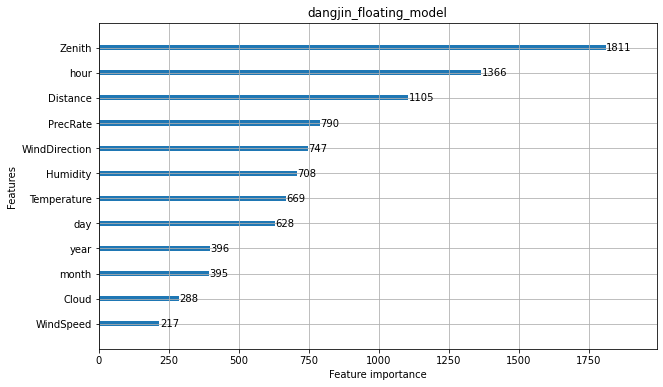

In [532]:
plot_importance(dangjin_floating_model, figsize=(10, 6), title='dangjin_floating_model');

In [533]:
dangjin_floating_weight = weight(dangjin_floating_model, 1000, val_x1, val_y1)
dangjin_floating_weight

1.08

### 모델 학습 (dangjin_warehouse)

In [534]:
train_dataset = lgb.Dataset(train_x2, train_y2)
val_dataset = lgb.Dataset(val_x2, val_y2)
capacity = 700
params2 = {'learning_rate': 0.01, 'objective': 'regression', 'metric':'logloss', 'seed':42}
# params2 = {'learning_rate': 0.04,
#            'objective': 'regression', 
#            'metric':'logloss', 
#            'seed': 42,
#            'max_depth': 8, 
#            'min_data_in_leaf': 20, 
#            'lambda': 0.6,
#            'bagging_fraction': 0.8,
#            'bagging_freq ': 0.8,
#            'feature_fraction': 0.8,
#            'lambda_l1' : 0.7,
#            'lambda_l2' : 0.5,
#            'boosting':'gbdt'}
dangjin_warehouse_model = lgb.train(params2, train_dataset, 10000, val_dataset, feval=nmae_10,
                                    verbose_eval=100, early_stopping_rounds=200)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1594
[LightGBM] [Info] Number of data points in the train set: 32611, number of used features: 12
[LightGBM] [Info] Start training from score 198.734507
Training until validation scores don't improve for 200 rounds
[100]	valid_0's score: 10.9784
[200]	valid_0's score: 9.86133
[300]	valid_0's score: 9.62098
[400]	valid_0's score: 9.6604
[500]	valid_0's score: 9.68617
Early stopping, best iteration is:
[359]	valid_0's score: 9.58213


In [535]:
sola_nmae(val_y2.values.reshape(-1), 
          dangjin_warehouse_model.predict(val_x2)*weight(dangjin_warehouse_model, 700, val_x2, val_y2), 700)

8.969437630708487

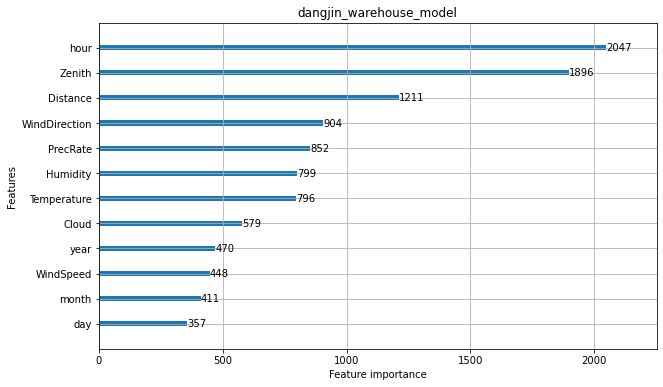

In [536]:
plot_importance(dangjin_warehouse_model, figsize=(10, 6), title='dangjin_warehouse_model');

In [537]:
dangjin_warehouse_weight = weight(dangjin_warehouse_model, 700, val_x2, val_y2)
dangjin_warehouse_weight

1.13

### 모델 학습 (dangjin)

In [538]:
train_dataset = lgb.Dataset(train_x3, train_y3)
val_dataset = lgb.Dataset(val_x3, val_y3)
capacity = 1000
params3 = {'learning_rate': 0.004, 'objective': 'regression', 'metric':'logloss', 'seed':42}
# params3 = {'learning_rate': 0.01,
#            'objective': 'regression', 
#            'metric':'logloss', 
#            'seed': 42,
#            'max_depth': 10, 
#            'min_data_in_leaf': 25, 
#            'lambda': 0.9,
#            'bagging_fraction': 1,
#            'bagging_freq ': 1,
#            'feature_fraction': 1,
#            'lambda_l1' : 1,
#            'lambda_l2' : 1}
dangjin_model = lgb.train(params3, train_dataset, 10000, val_dataset, feval=nmae_10,
                                    verbose_eval=200, early_stopping_rounds=200)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1582
[LightGBM] [Info] Number of data points in the train set: 30848, number of used features: 12
[LightGBM] [Info] Start training from score 310.384855
Training until validation scores don't improve for 200 rounds
[200]	valid_0's score: 11.9974
[400]	valid_0's score: 10.3324
[600]	valid_0's score: 9.87328
[800]	valid_0's score: 9.80685
Early stopping, best iteration is:
[773]	valid_0's score: 9.75834


In [539]:
sola_nmae(val_y3.values.reshape(-1), 
          dangjin_model.predict(val_x3)*weight(dangjin_model, 1000, val_x3, val_y3), 1000)

9.493170935247115

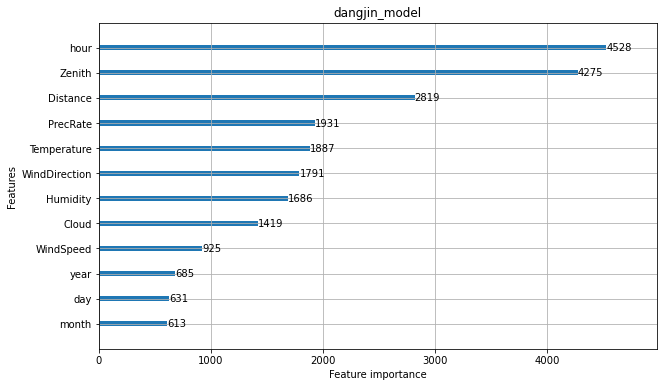

In [540]:
plot_importance(dangjin_model, figsize=(10, 6), title='dangjin_model');

In [541]:
dangjin_weight = weight(dangjin_model, 1000, val_x3, val_y3)
dangjin_weight

1.07

### 모델 학습 (ulsan)

In [542]:
train_dataset = lgb.Dataset(train_x4, train_y4)
val_dataset = lgb.Dataset(val_x4, val_y4)
capacity = 500
params4 = {'learning_rate': 0.02, 'objective': 'regression', 'metric':'logloss', 'seed':42}
#params4 = {'learning_rate': 0.01,
#            'objective': 'regression', 
#            'metric':'logloss', 
#            'seed': 42,
#            'max_depth': 7, 
#            'min_data_in_leaf': 25
# }
ulsan_model = lgb.train(params4, train_dataset, 10000, val_dataset, feval=nmae_10,
                                    verbose_eval=100, early_stopping_rounds=200)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1598
[LightGBM] [Info] Number of data points in the train set: 31588, number of used features: 12
[LightGBM] [Info] Start training from score 138.653096
Training until validation scores don't improve for 200 rounds
[100]	valid_0's score: 6.73707
[200]	valid_0's score: 5.66484
[300]	valid_0's score: 5.5527
[400]	valid_0's score: 5.50609
[500]	valid_0's score: 5.4891
[600]	valid_0's score: 5.49496
Early stopping, best iteration is:
[476]	valid_0's score: 5.48596


In [543]:
sola_nmae(val_y4.values.reshape(-1), 
          ulsan_model.predict(val_x4)*weight(ulsan_model, 500, val_x4, val_y4), 500)

5.485962922326779

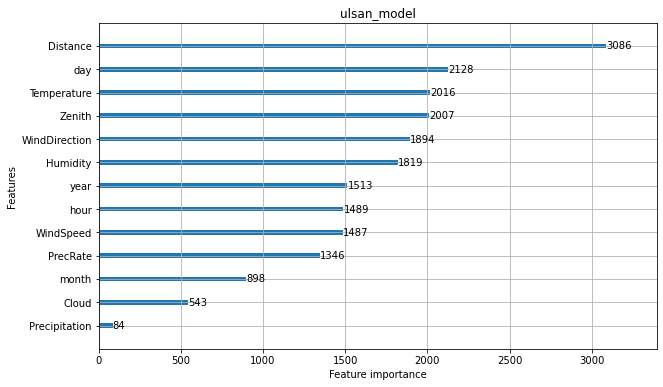

In [517]:
plot_importance(ulsan_model, figsize=(10, 6), title='ulsan_model');

In [518]:
ulsan_weight = weight(ulsan_model, 500, val_x4, val_y4)
ulsan_weight

1.0

## (3) Predict

### 학습한 모델을 이용하여 2021년 2월 발전량 예측

In [68]:
dangjin_floating_pred = dangjin_floating_model.predict(test_x1)
dangjin_warehouse_pred = dangjin_warehouse_model.predict(test_x2)
dangjin_pred = dangjin_model.predict(test_x3)
ulsan_pred = ulsan_model.predict(test_x4)

### 발전량에 각 가중치 부여

In [69]:
dangjin_floating_pred *= dangjin_floating_weight
dangjin_warehouse_pred *= dangjin_warehouse_weight
dangjin_pred *= dangjin_weight
ulsan_pred *= ulsan_weight

### 발전량 예측 시각화

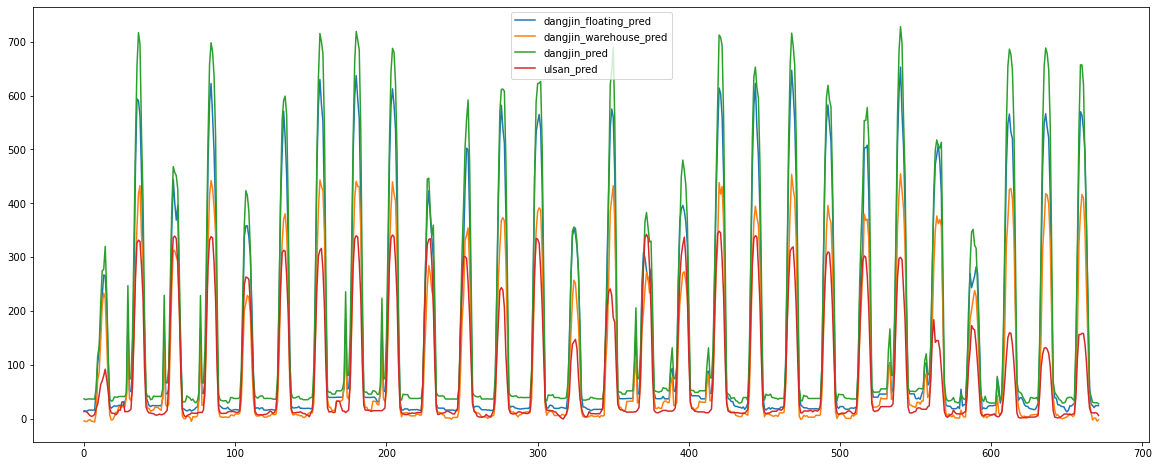

In [70]:
plt.figure(figsize=(20,8))
plt.plot(dangjin_floating_pred, label = 'dangjin_floating_pred')
plt.plot(dangjin_warehouse_pred, label = 'dangjin_warehouse_pred')
plt.plot(dangjin_pred, label = 'dangjin_pred')
plt.plot(ulsan_pred, label = 'ulsan_pred')
plt.legend()
plt.show()

In [71]:
sample_submission.iloc[:24*28, 1] = dangjin_floating_pred
sample_submission.iloc[:24*28, 2] = dangjin_warehouse_pred
sample_submission.iloc[:24*28, 3] = dangjin_pred
sample_submission.iloc[:24*28, 4] = ulsan_pred

In [72]:
#sample_submission.to_csv('submission/final.csv', index=False)